In [1]:
!pip install stemming

  Running setup.py bdist_wheel for stemming ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e8/05/2e/2ddeb64d4464b854b48323f9676528c17560da7d153db7b0e2
Successfully built stemming
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install textblob

    100% |████████████████████████████████| 645kB 21.8MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 21.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

# Data Cleaning

## Remove punctuations, special characters, 

In [8]:
df['clean_comments'] = df['comments'].str.replace("[^a-zA-Z#]", " ")

KeyError: 'comments'

In [ ]:
train.clean_comments

In [ ]:
train.dtypes
train = train.astype({"clean_comments": object})
train.dtypes

## Replace empty value with "Null" 
## Remove small words <=3 characters

In [ ]:
train['clean_comments'] = train['clean_comments'].fillna("Null")
train['clean_comments'] = train['clean_comments'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
train.clean_comments

# Tokenization

In [ ]:
from nltk.tokenize import sent_tokenize

tokenized_comments = train['clean_comments'].apply(lambda x: x.split())

word_tokens = tokenized_comments.apply(lambda x: [sent_tokenize(i) for i in x])
word_tokens.head()

# Lexicon Normalization

In [14]:
#considers a type of noise data that exists, which are related forms of a word to a root word

## Stemming (Remove suffixes)

In [15]:
#Stemmer works on an individual word without knowledge of the context

In [18]:
from nltk.stem.porter import *
from stemming.porter2 import stem

tokenized_comments = tokenized_comments.apply(lambda x: [stem(i) for i in x]) # stemming
tokenized_comments.head()

0    [Stephani, wonder, host, apart, beauti, extrem...
1    [delight, stay, Dana, fantast, locat, apart, j...
2    [Dana, place, charm, veri, well, locat, just, ...
3              [great, stay, would, recommend, anytim]
4    [Dana, warm, welcom, host, enjoy, stay, apart,...
Name: clean_comments, dtype: object

## Lemmatization

In [19]:
#Lemmatization reduces words to their base word

In [20]:
#Lexicon Normalization
#performing stemming and Lemmatization

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer

lem = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

#tokenized_comments = tokenized_comments.apply(lambda x: [for j in x [lem.lemmatize(i) for i in j]]) # lemmatizing
    
for word in tokenized_comments[0]:
    new_word = stemmer.stem(word)
    print(new_word)


stephani
wonder
host
apart
beauti
extrem
clean
veri
nice
afford
stay
citi
with
privat
room
bathroom


In [21]:
#stitch tokens back together

In [22]:
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = ' '.join(tokenized_comments[i])

train['clean_comments'] = tokenized_comments

In [23]:
train.head()

,listing_id,comments,clean_comments
0,2515,Stephanie was a wonderful host! Her apartment ...,Stephani wonder host apart beauti extrem clean...
1,21456,We had a delightful stay at Dana's fantastical...,delight stay Dana fantast locat apart just per...
2,21456,"Dana's place is charming, and very well-locate...",Dana place charm veri well locat just block aw...
3,21456,"great stay, i would recommend her anytime...",great stay would recommend anytim
4,21456,Dana is a warm and welcoming host. We enjoyed...,Dana warm welcom host enjoy stay apart apart c...


# Story Generation

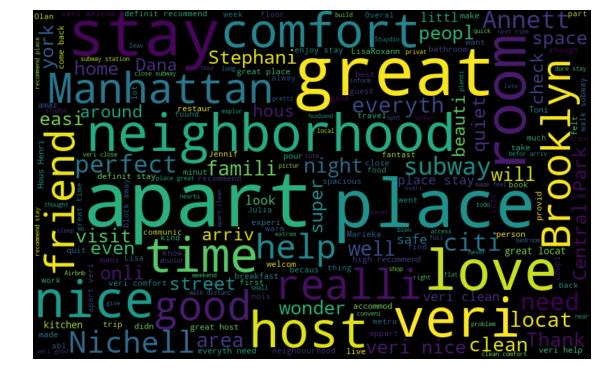

In [31]:
all_words = ' '.join([text for text in train['clean_comments']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# POS Tagging

In [32]:
import nltk

word_tokens.apply(lambda x: [nltk.pos_tag(i) for i in x])

LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  [0m
  Searched in:
    - '/home/ec2-user/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/home/ec2-user/anaconda3/envs/python3/nltk_data'
    - '/home/ec2-user/anaconda3/envs/python3/share/nltk_data'
    - '/home/ec2-user/anaconda3/envs/python3/lib/nltk_data'
**********************************************************************


In [ ]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

train[['negative', 'positive']] = train['clean_comments'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
train.head()

# Whats Left

## - Perform sentiment analysis on all 3 years of review data
## - Average listing_id positives and negatives
## - Merge to listing dataset by listing_id

In [ ]:
review_avg = train.drop(columns = ['comments', 'clean_comments'])
review_avg.head()

df_mean = review_avg.groupby(['listing_id'], as_index= False)[['positive','negative']].mean()
df_mean.head()
df_mean.info()

ds4 = pd.read_csv('s3://datasetairbnb/airbnb_cleaned.csv', encoding='Latin-1')
ds4.head()

new_df = pd.merge(ds4, df_mean, left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
new_df.columns
new_df.head()